(toolboxes:analyze_everything)=
# Analyze everything

This notebook demonstrates how to run a complete STRESS analysis in a few lines of code and produce all relevant output graphs.

In [1]:
import napari_stress
import napari
import numpy as np
from napari_stress import reconstruction, approximation, measurements, frame_by_frame, TimelapseConverter
import napari_process_points_and_surfaces as nppas
import vedo
import os

from skimage import io

from scipy import stats

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

## Config

For plotting:

In [2]:
save_directory = 'path/to/save/directory'
colormap = 'seismic'

### Data dimensions
You need to set a few parameters pertaining to your data:

In [3]:
voxel_size_x = 1.0  # microns
voxel_size_y = 1.0  # microns
voxel_size_z = 1.93  # microns
target_voxel_size = 1.0  # microns
time_step = 60  # seconds

### Droplet reconstruction parameters

All of the parameters are explained in more detail [here](point_and_click:droplet_reconstruction).

In [4]:
n_smoothing_iterations = 10
n_points_first_guess = 256
n_tracing_iterations = 1
resampling_length = 1
fit_type = 'fancy'  # can be 'fancy' or 'quick'
edge_type = 'interior'  # can be 'interior' or 'surface'
trace_length = 10
trace_sampling_distance = 0.5

*Hint:* Not sure whether the code is running probably? To show a progress bar for the processing of each timeframe, set the `verbose` parameter to `True`:

In [5]:
verbose = False

### Stress analysis parameters
All of the used parameters are explained in more detail [here](point_and_click:stress_toolbox).

In [6]:
max_degree = 10  # spherical harmonics degree
n_quadrature_points = 434  # number of quadrature points to measure on (maximum is 5180)
gamma = 6.0  # interfacial tension of droplet

# Analysis

In [7]:
viewer = napari.Viewer(ndisplay=3)

27-Jan-23 18:15:19 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 2172x1352+1280+534 (frame: 2198x1423+1267+476) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 4350x2119+1285+561 (frame: 4376x2190+1272+503) margins: 13, 58, 13, 13 minimum size: 374x560 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=774,1191 maxtrack=0,0)


## Load the data

Replace the following code with the commented out part below to load your own data for analysis:

In [8]:
example_data = napari_stress.get_droplet_4d()[0][0]
example_data.shape

# Replace this code with a command to import your data. Example:
# example_data = io.imread('path/to/data.tif')

(21, 16, 30, 31)

In [9]:
n_frames = example_data.shape[0]

In [10]:
viewer.add_image(example_data)

<Image layer 'example_data' at 0x240c3127b50>

In [11]:
results_reconstruction = reconstruction.reconstruct_droplet(example_data,
                                                            voxelsize=np.asarray([voxel_size_z, voxel_size_y, voxel_size_x]),
                                                            target_voxelsize=target_voxel_size,
                                                            n_smoothing_iterations=n_smoothing_iterations,
                                                            n_points=n_points_first_guess,
                                                            n_tracing_iterations=n_tracing_iterations,
                                                            resampling_length=resampling_length,
                                                            fit_type=fit_type,
                                                            edge_type=edge_type,
                                                            trace_length=trace_length,
                                                            sampling_distance=trace_sampling_distance,
                                                            verbose=verbose
                                                            )

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [12]:
for res in results_reconstruction:
    if res[2] == 'image':
        viewer.add_image(res[0], **res[1])
    elif res[2] == 'points':
        viewer.add_points(res[0], **res[1])
    elif res[2] == 'vectors':
        viewer.add_vectors(res[0], **res[1])
refined_points = results_reconstruction[3]

We need the refined points to continue:

In [13]:
results_stress_analysis = measurements.comprehensive_analysis(refined_points[0],
                                                              max_degree=max_degree,
                                                              n_quadrature_points=n_quadrature_points,
                                                              gamma=gamma,
                                                              verbose=verbose)
for res in results_stress_analysis:
    if res[2] == 'points':
        viewer.add_points(res[0], **res[1])
    if res[2] == 'vectors':
        viewer.add_vectors(res[0], **res[1])

To get an idea about the returned outputs and which is stored in which layer, let's print them:

In [14]:
for res in results_stress_analysis:
    print('-->', res[1]['name'])
    if 'metadata' in res[1].keys():
        for key in res[1]['metadata'].keys():
            print('\t Metadata: ', key)
    if 'features' in res[1].keys():
        for key in res[1]['features'].keys():
            print('\t Features: ', key)

--> Result of fit spherical harmonics (deg = 10
	 Metadata:  Elipsoid_deviation_contribution_matrix
	 Features:  fit_residue
--> Result of expand points on ellipsoid
	 Features:  fit_residue
--> Result of least squares ellipsoid
--> Result of lebedev quadrature on ellipsoid
	 Metadata:  Tissue_stress_tensor_cartesian
	 Metadata:  Tissue_stress_tensor_elliptical
	 Metadata:  max_issue_stress_anisotropy
	 Features:  mean_curvature
	 Features:  anisotropic_stress_tissue
--> Result of lebedev quadrature (droplet)
	 Metadata:  Gauss_Bonnet_relative_error
	 Metadata:  Gauss_Bonnet_error
	 Metadata:  Gauss_Bonnet_error_radial
	 Metadata:  Gauss_Bonnet_relative_error_radial
	 Metadata:  H0_volume_integral
	 Metadata:  H0_arithmetic
	 Metadata:  H0_surface_integral
	 Metadata:  S2_volume_integral
	 Features:  mean_curvature
	 Features:  difference_mean_curvature_cartesian_radial_manifold
	 Features:  anisotropic_stress_cell
	 Features:  anisotropic_stress
	 Features:  anisotropic_stress_total_r

To make handling further down easier, we store all metadata in a single dataframe if its length corresponds to the number of frames in the data:

In [15]:
_metadata = [layer[1]['metadata'] for layer in results_stress_analysis if 'metadata' in layer[1].keys()]
df_over_time = {}
df_over_time['frame'] = np.arange(n_frames)
for meta in _metadata:
    for key in meta.keys():
        if type(meta[key][0]) == dict:
            for key2 in meta[key][0].keys():
                v = [dic[key2] for dic in meta[key]]
                df_over_time[key2] = v
        else:
            df_over_time[key] = meta[key]
df_over_time = pd.DataFrame(df_over_time)
df_over_time['time'] = df_over_time['frame'] * time_step


# Visualization

In [16]:
mpl.style.use('default')

In [17]:
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

## Fit errors

We first show all the errors that were calculated during the pointcloud refinement:

In [18]:
fit_error_df = pd.DataFrame(results_reconstruction[3][1]['features'])
fit_error_df

,center,amplitude,slope,offset,center_err,amplitude_err,slope_err,idx_of_border
0,10.497403,0.650988,1.070623,0.000897,0.032665,0.004451,0.032655,10.497403
1,10.499875,0.693017,1.189679,0.001705,0.041273,0.006222,0.050816,10.499875
2,10.341052,0.680734,1.251979,0.001392,0.044869,0.006761,0.061146,10.341052
3,10.046747,0.626645,0.884935,-0.000911,0.051591,0.006323,0.035537,10.046747
4,10.826167,0.641000,0.975620,0.001235,0.042623,0.005579,0.035487,10.826167
...,...,...,...,...,...,...,...,...
8230,10.788128,0.698571,1.092446,0.004173,0.053015,0.007851,0.055149,10.788128
8231,11.046021,0.617504,1.213993,0.004296,0.042078,0.005761,0.053970,11.046021
8232,10.387762,0.652343,1.249137,0.003048,0.041704,0.006020,0.056565,10.387762
8233,10.395517,0.645982,1.215486,0.005606,0.054240,0.007673,0.069694,10.395517


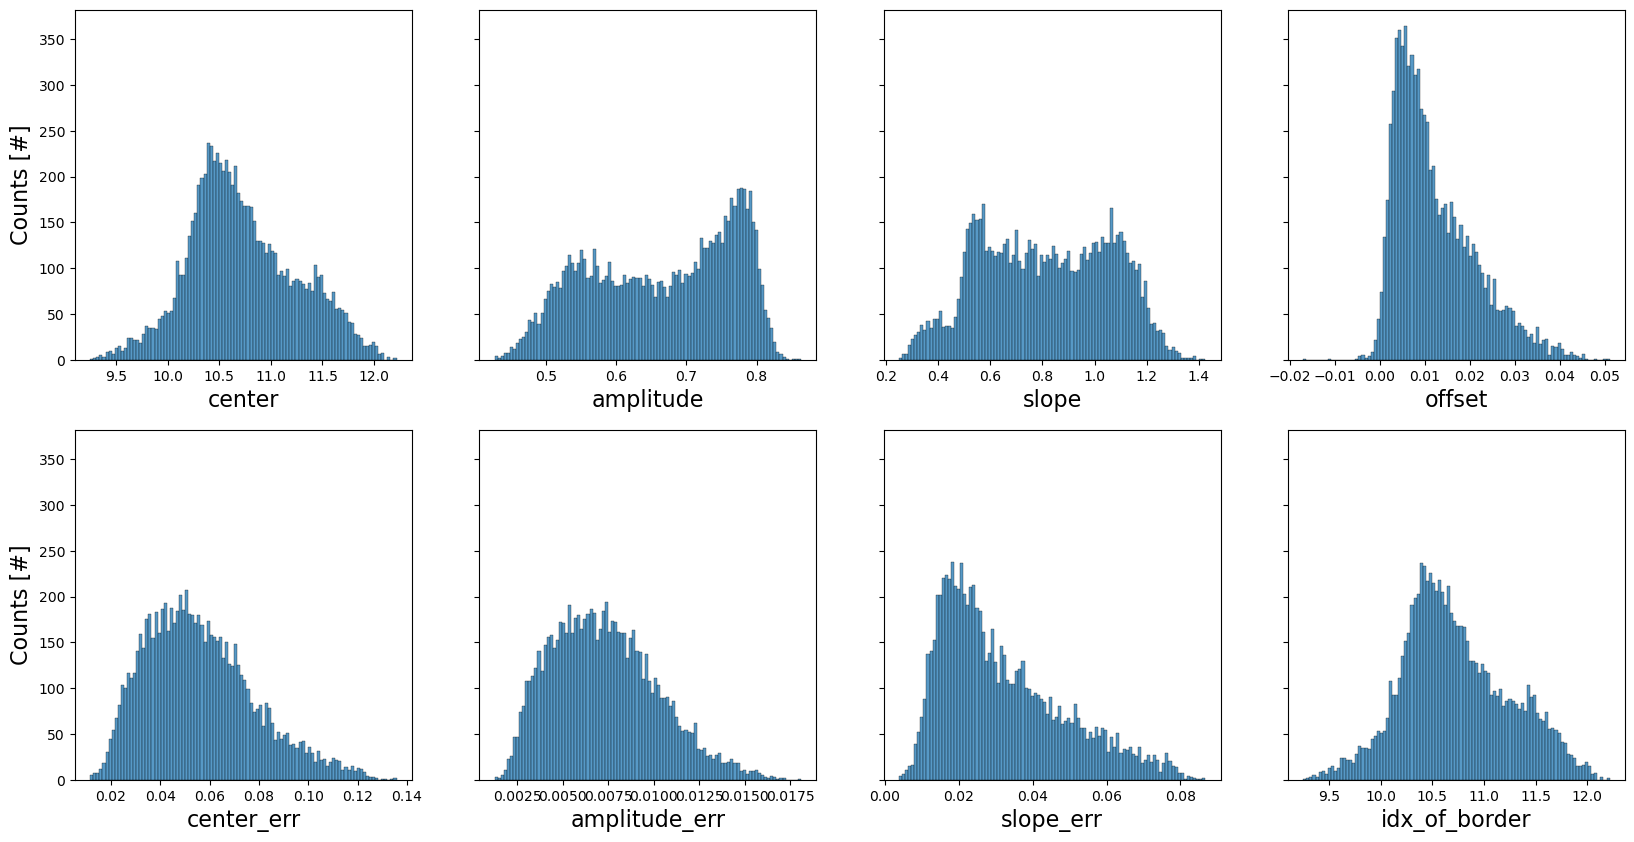

In [19]:
fig, axes = plt.subplots(ncols=4, nrows=len(fit_error_df.columns)//4, figsize=(20, 10), sharey=True)
axes = axes.flatten()
for idx, column in enumerate(fit_error_df.columns):
    ax = axes[idx]

    sns.histplot(data=fit_error_df, x=column, ax=ax, bins=100)
    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Counts [#]', fontsize=16)

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'fit_error_reconstruction.png'), dpi=300)

## Spherical harmonics

### Fit residue

We now show the errors made when approximating the reconstructed pointcloud with the spherical harmonics:

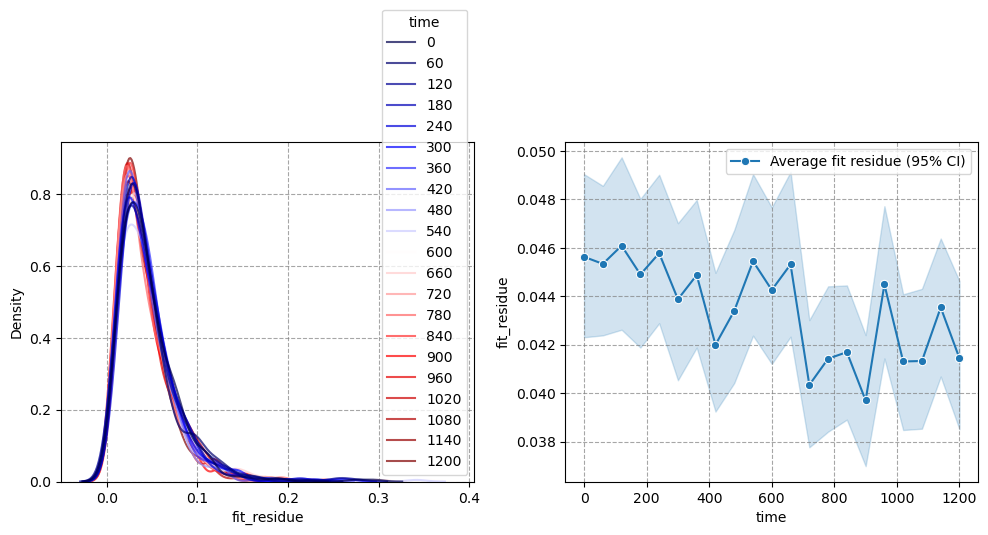

In [20]:
spherical_harmonics_data = results_stress_analysis[0]
df = pd.DataFrame(spherical_harmonics_data[1]['features'])
df['time'] = spherical_harmonics_data[0][:, 0].astype(int) * time_step

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.kdeplot(data=df, x='fit_residue', hue='time', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df, x='time', y='fit_residue', ci=95, ax=axes[1], legend=True, label='Average fit residue (95% CI)', marker='o')

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'fit_error_spherical_harmonics.png'), dpi=300)

### Fit quality

We can quantify the quality of the extracted pointcloud by using the absolute and relative Gauss-Bonnet errors:

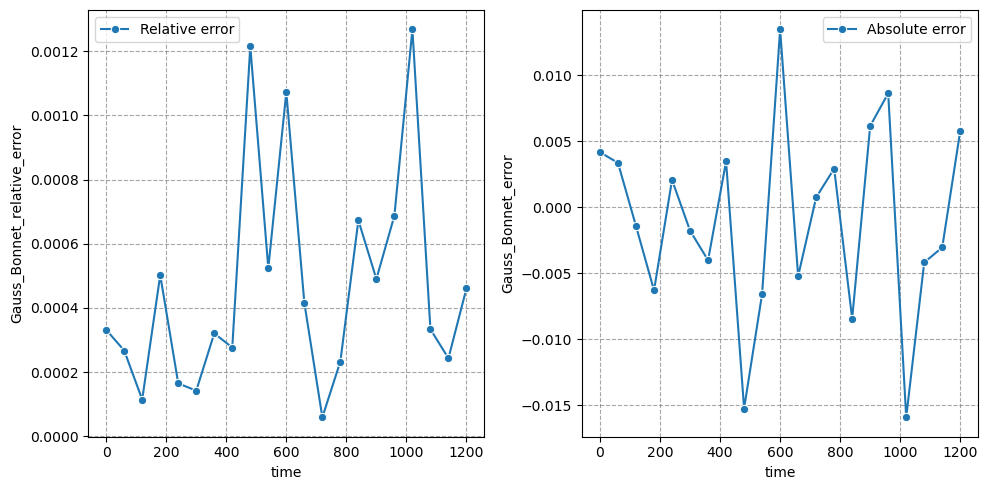

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.lineplot(data=df_over_time, x='time', y='Gauss_Bonnet_relative_error', legend=True, label='Relative error', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='time', y='Gauss_Bonnet_error', legend=True, label='Absolute error', marker='o', ax=axes[1])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'fit_error_gauss_bonnet.png'), dpi=300)

## Curvature

We next show mean curvature histograms and averages over time:

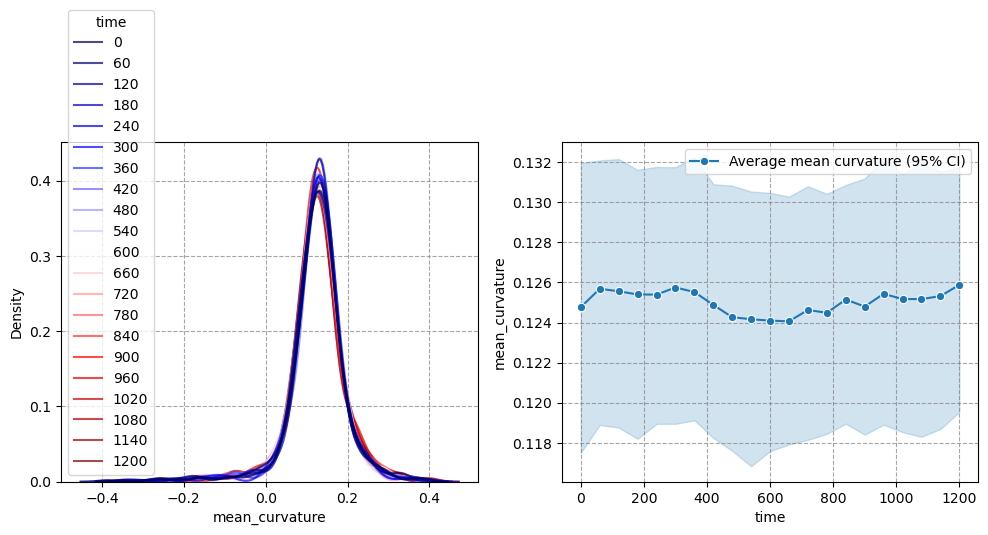

In [22]:
mean_curvature_data = results_stress_analysis[4]

df = pd.DataFrame(mean_curvature_data[1]['features'])
df['time'] = mean_curvature_data[0][:, 0].astype(int) * time_step

fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.kdeplot(data=df, x='mean_curvature', hue='time', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df, x='time', y='mean_curvature', ci=95, ax=axes[1], legend=True, label='Average mean curvature (95% CI)', marker='o')

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'mean_curvature.png'), dpi=300)

### Total stress

In [23]:
alpha=0.05

In [24]:
total_anisotropic_stress_data = results_stress_analysis[4]
df_total_stress = pd.DataFrame(total_anisotropic_stress_data[1]['features'])
df_total_stress['time'] = total_anisotropic_stress_data[0][:, 0] * time_step

total_stress_anisotropy = []
for t in range(n_frames):
    subset_t = df_total_stress[df_total_stress['time']==t]['anisotropic_stress']
    hist_data = np.histogram(subset_t, bins='auto', density=True)
    hist_dist = stats.rv_histogram(hist_data)
    
    smallest_excluded_value = hist_dist.ppf(alpha)
    largest_excluded_value = hist_dist.ppf(1. - alpha)
    total_stress_anisotropy.append(largest_excluded_value - smallest_excluded_value)

df_over_time['total_stress_anisotropy'] = total_stress_anisotropy

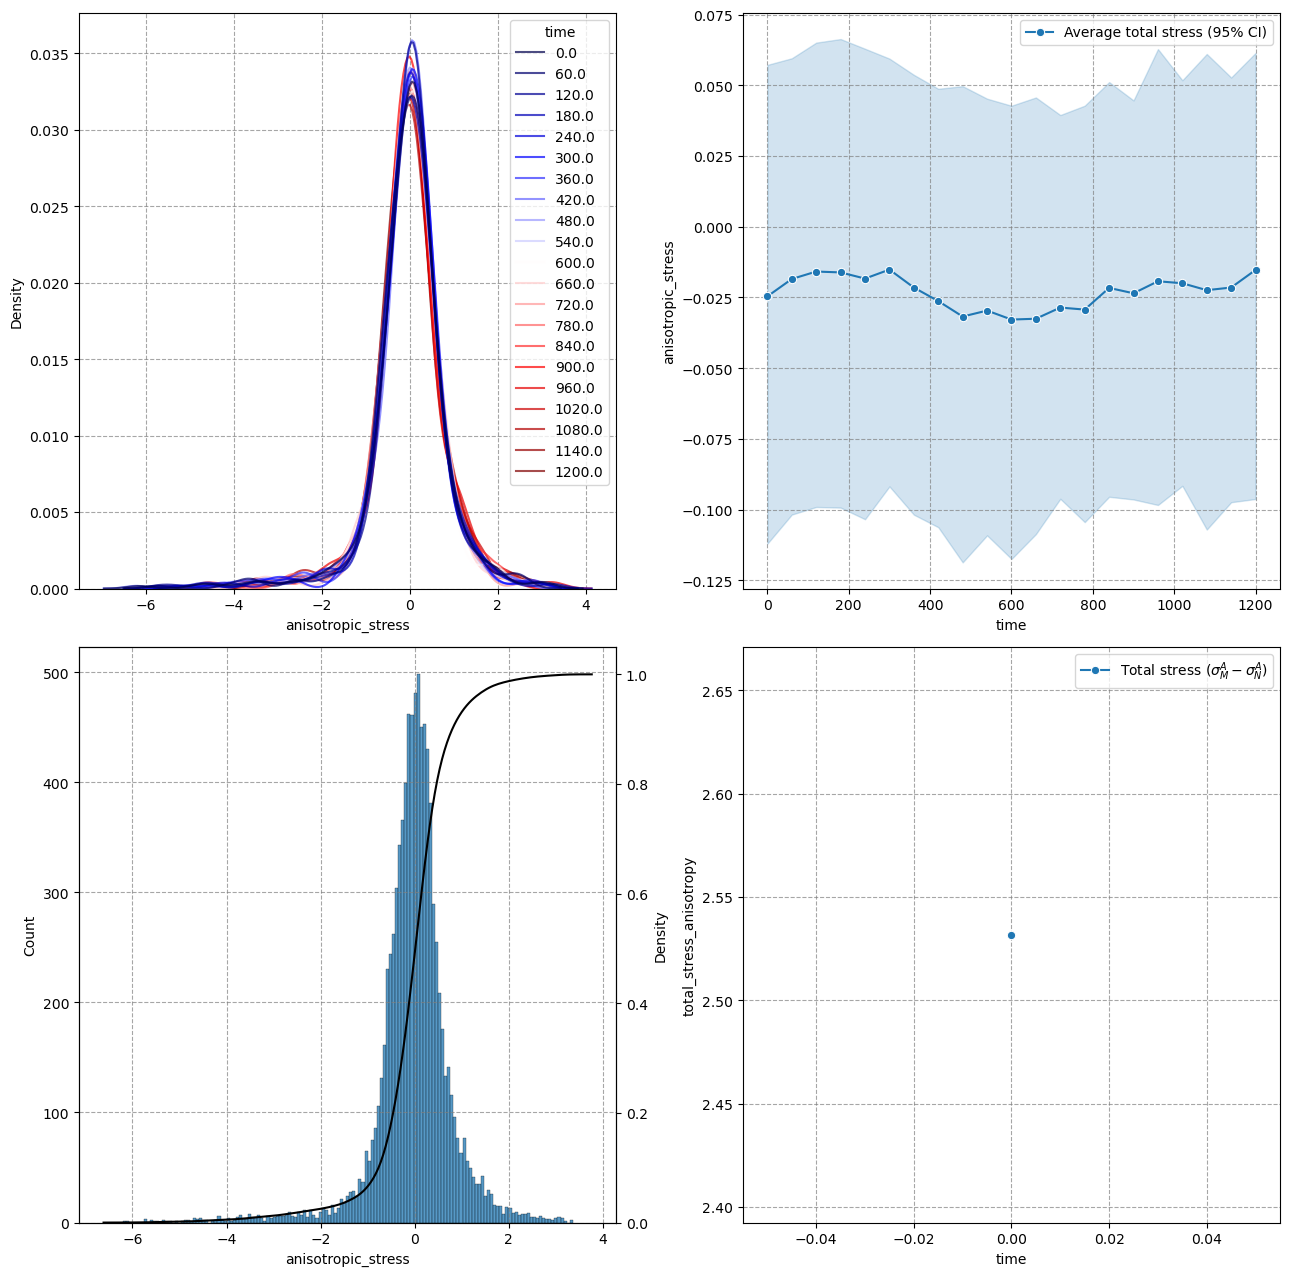

In [25]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(13,13))
axes = axes.flatten()
_ax2 = axes[2].twinx()
sns.kdeplot(data=df_total_stress, x='anisotropic_stress', hue='time', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df_total_stress, x='time', y='anisotropic_stress', ci=95, ax=axes[1], legend=True, label='Average total stress (95% CI)', marker='o')
sns.histplot(data=df_total_stress, x='anisotropic_stress', ax=axes[2], label='Histogram (all frames combined)', legend=True)
sns.kdeplot(data=df_total_stress, x='anisotropic_stress', ax=_ax2, cumulative=True, label='Cumulative density function (all frames combined)', fill=False, color='black')
sns.lineplot(data=df_over_time, x='time', y = 'total_stress_anisotropy', label='Total stress ($\sigma^A_M -  \sigma^A_N$)', marker='o', ax=axes[3])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_anisotropy_total.png'), dpi=300)

### Cell-scale stress

In [26]:
alpha=0.05

In [27]:
total_anisotropic_stress_data = results_stress_analysis[4]
df_cell_stress = pd.DataFrame(total_anisotropic_stress_data[1]['features'])
df_cell_stress['time'] = total_anisotropic_stress_data[0][:, 0] * time_step

cell_stress_anisotropy = []
for t in range(n_frames):
    subset_t = df_cell_stress[df_cell_stress['time']==t]['anisotropic_stress_cell']
    hist_data = np.histogram(subset_t, bins='auto', density=True)
    hist_dist = stats.rv_histogram(hist_data)
    
    smallest_excluded_value = hist_dist.ppf(alpha)
    largest_excluded_value = hist_dist.ppf(1. - alpha)
    cell_stress_anisotropy.append(largest_excluded_value - smallest_excluded_value)

df_over_time['cell_stress_anisotropy'] = cell_stress_anisotropy

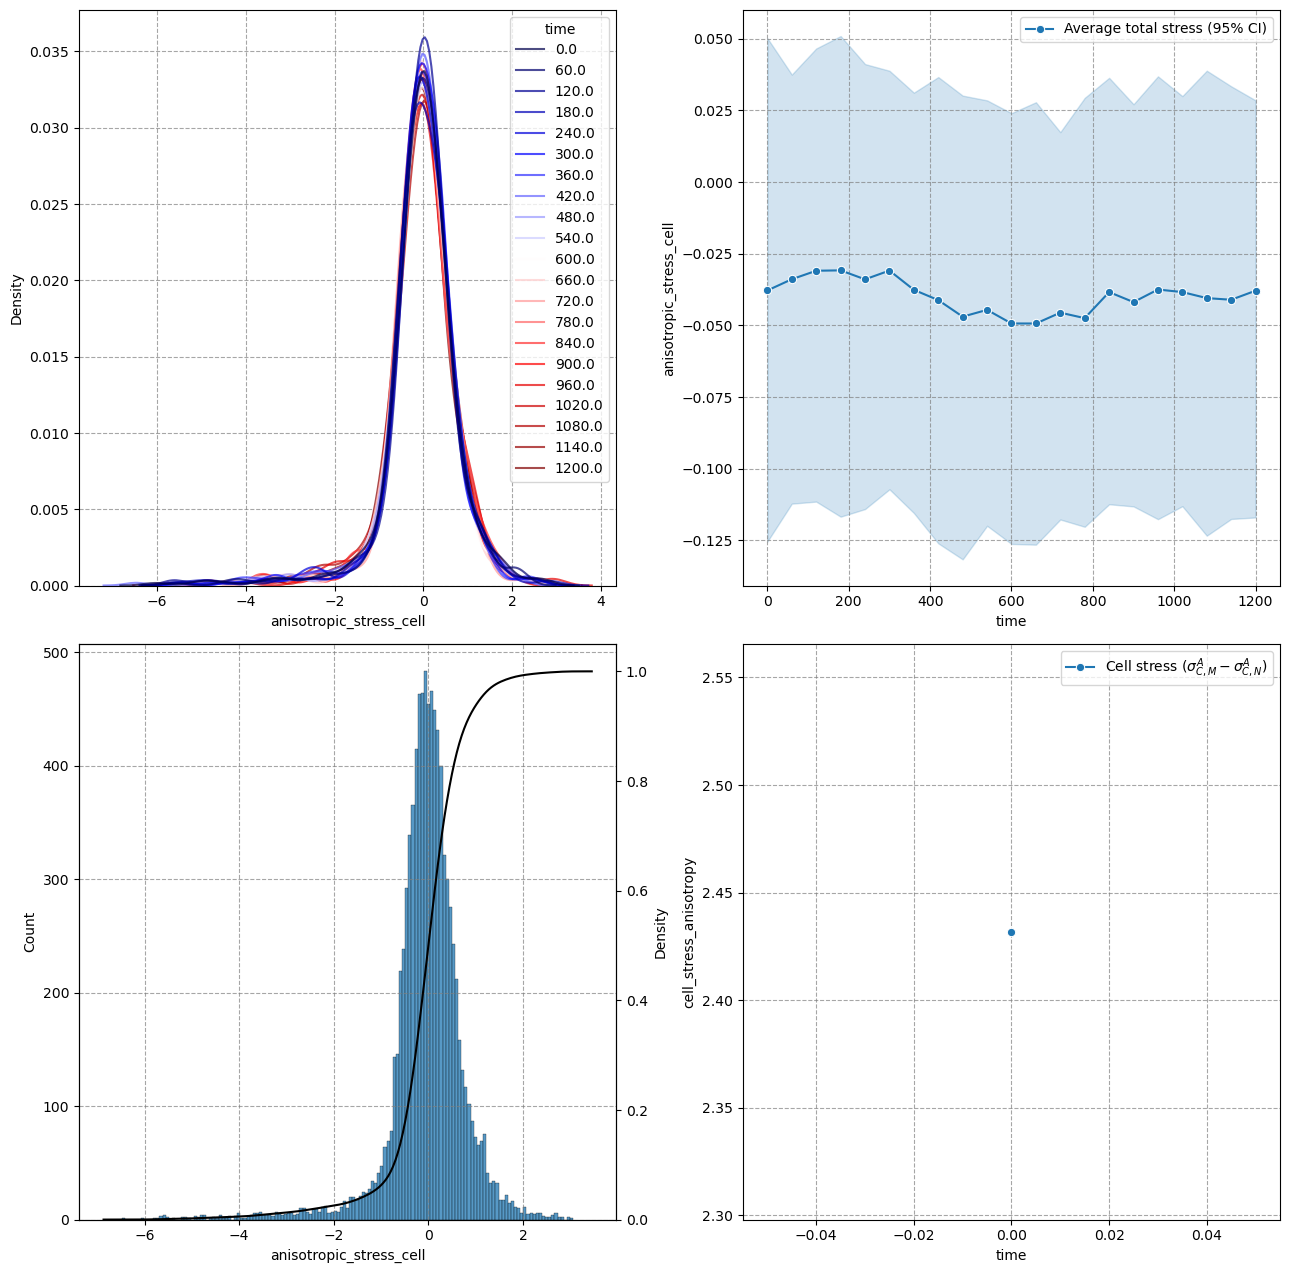

In [28]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(13,13))
axes = axes.flatten()
_ax2 = axes[2].twinx()
sns.kdeplot(data=df_cell_stress, x='anisotropic_stress_cell', hue='time', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df_cell_stress, x='time', y='anisotropic_stress_cell', ci=95, ax=axes[1], legend=True, label='Average total stress (95% CI)', marker='o')
sns.histplot(data=df_cell_stress, x='anisotropic_stress_cell', ax=axes[2], label='Histogram (all frames combined)', legend=True)
sns.kdeplot(data=df_cell_stress, x='anisotropic_stress_cell', ax=_ax2, cumulative=True, label='Cumulative density function (all frames combined)', fill=False, color='black')
sns.lineplot(data=df_over_time, x='time', y = 'cell_stress_anisotropy', label='Cell stress ($\sigma^A_{C,M} -  \sigma^A_{C,N}$)', marker='o', ax=axes[3])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)
fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_anisotropy_cell.png'), dpi=300)

## Tissue-scale stresses

In [29]:
tissue_anisotropic_stress_data = results_stress_analysis[3]
df_tissue_stress = pd.DataFrame(tissue_anisotropic_stress_data[1]['features'])
df_tissue_stress['time'] = total_anisotropic_stress_data[0][:, 0] * time_step
df_over_time['max_tissue_stress_anisotropy'] = tissue_anisotropic_stress_data[1]['metadata']['max_issue_stress_anisotropy']

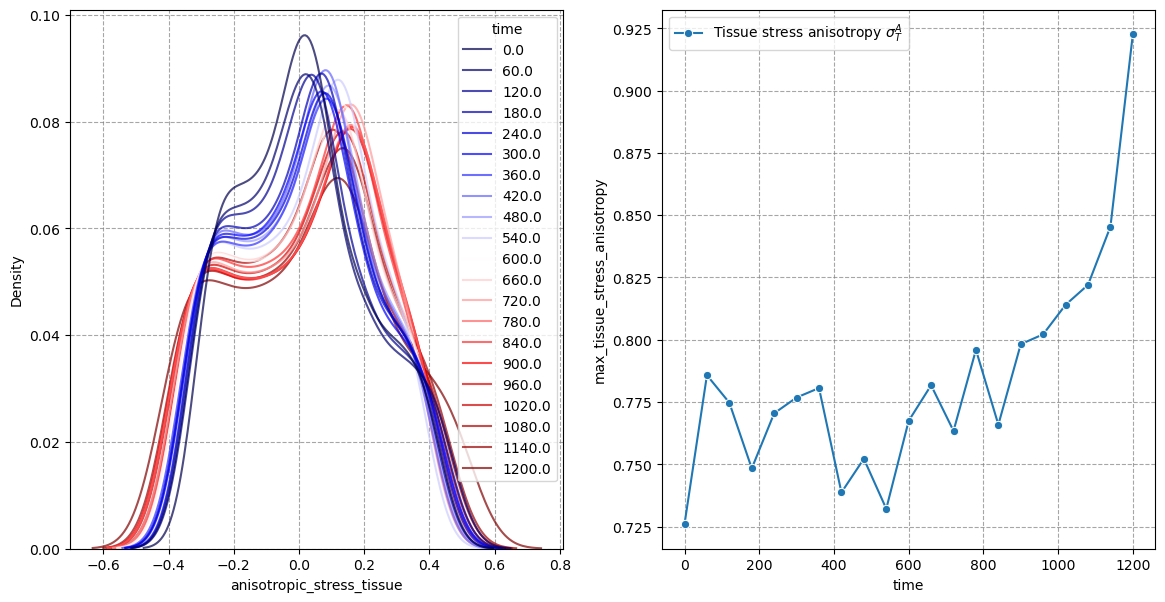

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(14,7))
axes = axes.flatten()
sns.kdeplot(data=df_tissue_stress, x='anisotropic_stress_tissue', hue='time', ax=axes[0], palette=colormap, alpha=0.7)
sns.lineplot(data=df_over_time, x='time', y = 'max_tissue_stress_anisotropy',
             label='Tissue stress anisotropy $\sigma^A_T$', marker='o', ax=axes[1])

for ax in axes:
    ax.grid(which='major', linestyle='--', color='gray', alpha=0.7)

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_anisotropy_tissue.png'), dpi=300)

## Stress along axes

In [31]:
tissue_anisotropic_stress_data = results_stress_analysis[3]
tissue_tensor_elliptical = np.stack(tissue_anisotropic_stress_data[1]['metadata']['Tissue_stress_tensor_elliptical'])
tissue_tensor_cartesian = np.stack(tissue_anisotropic_stress_data[1]['metadata']['Tissue_stress_tensor_cartesian'])
df_over_time['stress_along_e1'] = tissue_tensor_elliptical[:, 0, 0]
df_over_time['stress_along_e2'] = tissue_tensor_elliptical[:, 1, 1]
df_over_time['stress_along_e3'] = tissue_tensor_elliptical[:, 2, 2]
df_over_time['stress_anisotropy_e13'] = df_over_time['stress_along_e1'] - df_over_time['stress_along_e3']
df_over_time['stress_anisotropy_e12'] = df_over_time['stress_along_e1'] - df_over_time['stress_along_e2']
df_over_time['stress_anisotropy_e23'] = df_over_time['stress_along_e2'] - df_over_time['stress_along_e3']

In [32]:
angles = np.zeros((n_frames, 3))
for i in range(n_frames):
    _tissue_tensor_elliptical = tissue_tensor_elliptical[i]
    _tissue_tensor_cartesian = tissue_tensor_cartesian[i]
    for j in range(3):
        dot_product = np.dot(_tissue_tensor_cartesian[:, j], _tissue_tensor_elliptical[:, 0])
        norm = np.linalg.norm(_tissue_tensor_cartesian[:, j]) * np.linalg.norm(_tissue_tensor_elliptical[:, 0])
        angles[i, j] = np.arccos(dot_product/norm)*180/np.pi

df_over_time['angle_x1_e1'] = angles[:, 0]
df_over_time['angle_x2_e1'] = angles[:, 1]
df_over_time['angle_x3_e1'] = angles[:, 2]

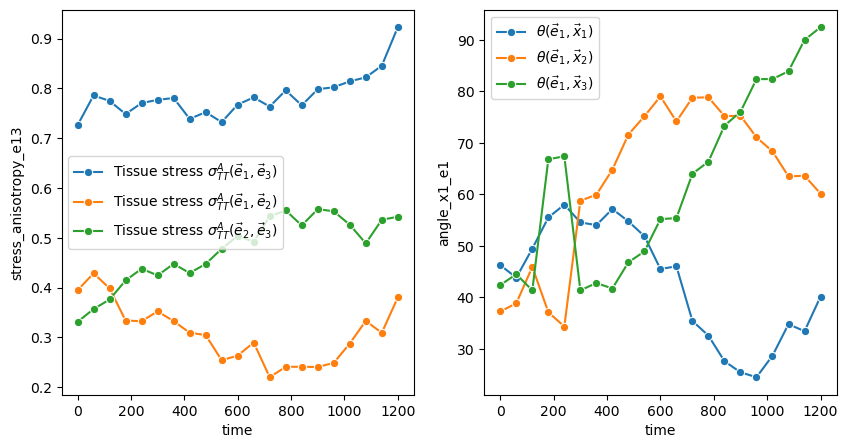

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
sns.lineplot(data=df_over_time, x='time', y = 'stress_anisotropy_e13', label='Tissue stress $\sigma^A_{TT}(\\vec{e}_1, \\vec{e}_3)$', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='time', y = 'stress_anisotropy_e12', label='Tissue stress $\sigma^A_{TT}(\\vec{e}_1, \\vec{e}_2)$', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='time', y = 'stress_anisotropy_e23', label='Tissue stress $\sigma^A_{TT}(\\vec{e}_2, \\vec{e}_3)$', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='time', y = 'angle_x1_e1', label='$\\theta (\\vec{e}_1, \\vec{x}_1)$', marker='o', ax=axes[1])
sns.lineplot(data=df_over_time, x='time', y = 'angle_x2_e1', label='$\\theta (\\vec{e}_1, \\vec{x}_2)$', marker='o', ax=axes[1])
sns.lineplot(data=df_over_time, x='time', y = 'angle_x3_e1', label='$\\theta (\\vec{e}_1, \\vec{x}_3)$', marker='o', ax=axes[1])

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_anisotropy_tissue_eigenvectors.png'), dpi=300)

## Geodesics

In [34]:
extrema_cell_stress_data = results_stress_analysis[6]
metadata = extrema_cell_stress_data[1]['metadata']

In [35]:
frames = np.concatenate([[i] * len(metadata['min_max_pair_distances'][i]) for i in range(n_frames)]) * time_step
min_max_pair_distances = np.concatenate(extrema_cell_stress_data[1]['metadata']['min_max_pair_distances'])
min_max_pair_anisotropies = np.concatenate(extrema_cell_stress_data[1]['metadata']['min_max_pair_anisotropies'])
df_all_pairs = pd.DataFrame(np.stack([frames.astype(int), min_max_pair_distances, min_max_pair_anisotropies]).T,
                            columns = ['time', 'min_max_pair_distances', 'min_max_pair_anisotropies'])

In [36]:
frames = np.concatenate([[i] * len(metadata['nearest_min_max_dists'][i]) for i in range(n_frames)]) * time_step
nearest_min_max_distances = np.concatenate(extrema_cell_stress_data[1]['metadata']['nearest_min_max_dists'])
nearest_min_max_anisotropies = np.concatenate(extrema_cell_stress_data[1]['metadata']['nearest_min_max_anisotropies'])
df_nearest_extrema_pairs = pd.DataFrame(np.stack([frames.astype(int), nearest_min_max_distances, nearest_min_max_anisotropies]).T,
                                        columns = ['time', 'nearest_min_max_dists', 'nearest_min_max_anisotropies'])
df_nearest_extrema_pairs = df_nearest_extrema_pairs[df_nearest_extrema_pairs['nearest_min_max_dists'] != 0]

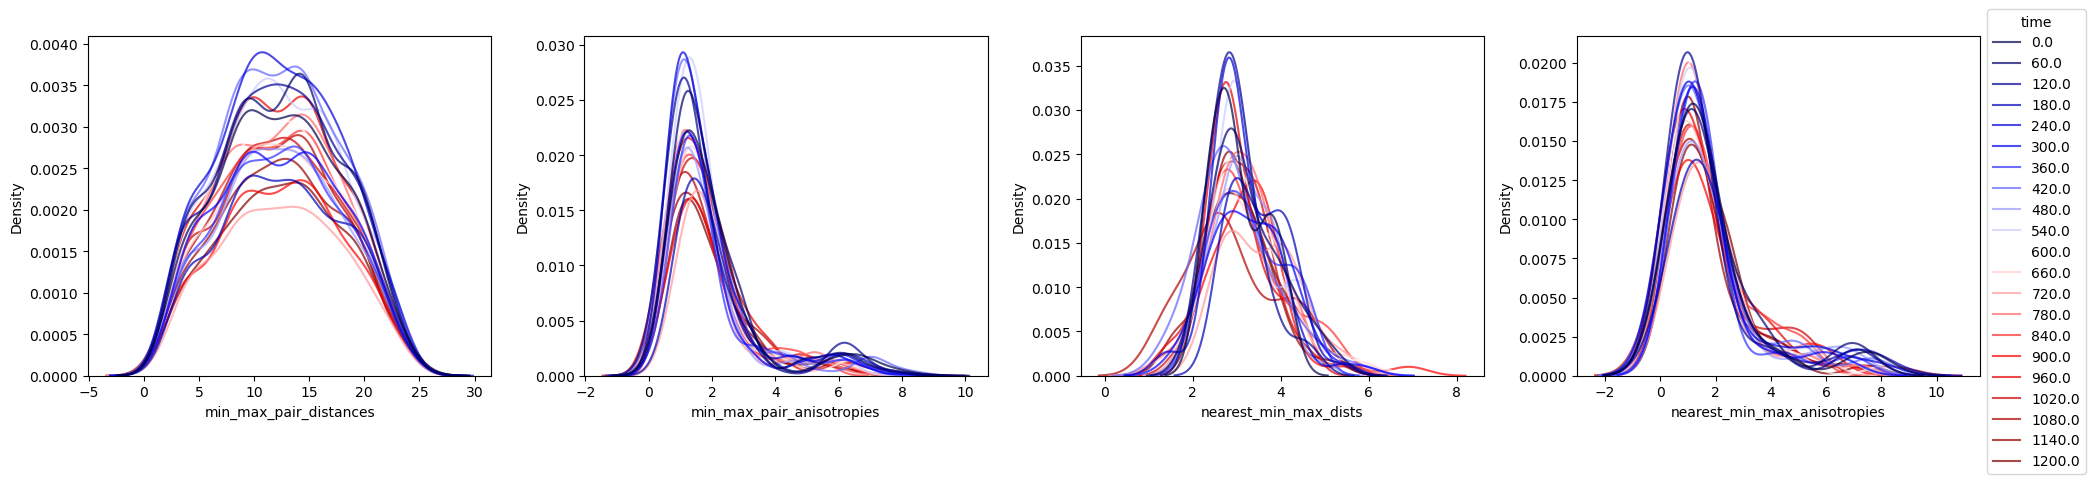

In [37]:
fig, axes = plt.subplots(ncols=4, figsize=(20,5))
sns.kdeplot(data=df_all_pairs, x='min_max_pair_distances', hue='time', ax=axes[0], palette=colormap, alpha=0.7, legend=False)
sns.kdeplot(data=df_all_pairs, x='min_max_pair_anisotropies', hue='time', ax=axes[1], palette=colormap, alpha=0.7, legend=False)
sns.kdeplot(data=df_nearest_extrema_pairs, x='nearest_min_max_dists', hue='time', ax=axes[2], palette=colormap, alpha=0.7, legend=False)
sns.kdeplot(data=df_nearest_extrema_pairs, x='nearest_min_max_anisotropies', hue='time', ax=axes[3], palette=colormap, alpha=0.7)

fig.tight_layout()
leg = axes[-1].get_legend()
leg.set_bbox_to_anchor(bbox=(1, 1.1))

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_anisotropy_nearest_extrema_pairs.png'), dpi=300)

##  Autocorrelations: Spatial

In [38]:
autocorrelations_data = results_stress_analysis[11]
metadata = autocorrelations_data[1]['metadata']

In [39]:
distances = [metadata['autocorrelations_total'][t]['auto_correlations_distances'] for t in range(n_frames)]
normalized_autocorrelation_total = [metadata['autocorrelations_total'][t]['auto_correlations_averaged_normalized'] for t in range(n_frames)]
frames = [[t] * len(metadata['autocorrelations_total'][t]['auto_correlations_averaged_normalized']) for t in range(n_frames)]

df_autocorrelations_total = pd.DataFrame(np.stack([np.concatenate(frames).squeeze() * time_step,
                                         np.concatenate(distances).squeeze(),
                                         np.concatenate(normalized_autocorrelation_total).squeeze(),
                                         ]).T, columns=['time',  'distances', 'autocorrelation_total'])

In [40]:
distances = [metadata['autocorrelations_cell'][t]['auto_correlations_distances'] for t in range(n_frames)]
normalized_autocorrelation_cell = [metadata['autocorrelations_cell'][t]['auto_correlations_averaged_normalized'] for t in range(n_frames)]
frames = [[t] * len(metadata['autocorrelations_cell'][t]['auto_correlations_averaged_normalized']) for t in range(n_frames)]

df_autocorrelations_cell = pd.DataFrame(np.stack([np.concatenate(frames).squeeze() * time_step,
                                         np.concatenate(distances).squeeze(),
                                         np.concatenate(normalized_autocorrelation_cell).squeeze(),
                                         ]).T, columns=['time',  'distances', 'autocorrelation_cell'])

In [41]:
distances = [metadata['autocorrelations_tissue'][t]['auto_correlations_distances'] for t in range(n_frames)]
normalized_autocorrelation_tissue = [metadata['autocorrelations_tissue'][t]['auto_correlations_averaged_normalized'] for t in range(n_frames)]
frames = [[t] * len(metadata['autocorrelations_tissue'][t]['auto_correlations_averaged_normalized']) for t in range(n_frames)]

df_autocorrelations_tissue = pd.DataFrame(np.stack([np.concatenate(frames).squeeze() * time_step,
                                         np.concatenate(distances).squeeze(),
                                         np.concatenate(normalized_autocorrelation_tissue).squeeze()
                                         ]).T, columns=['time',  'distances', 'normalized_autocorrelation_tissue'])

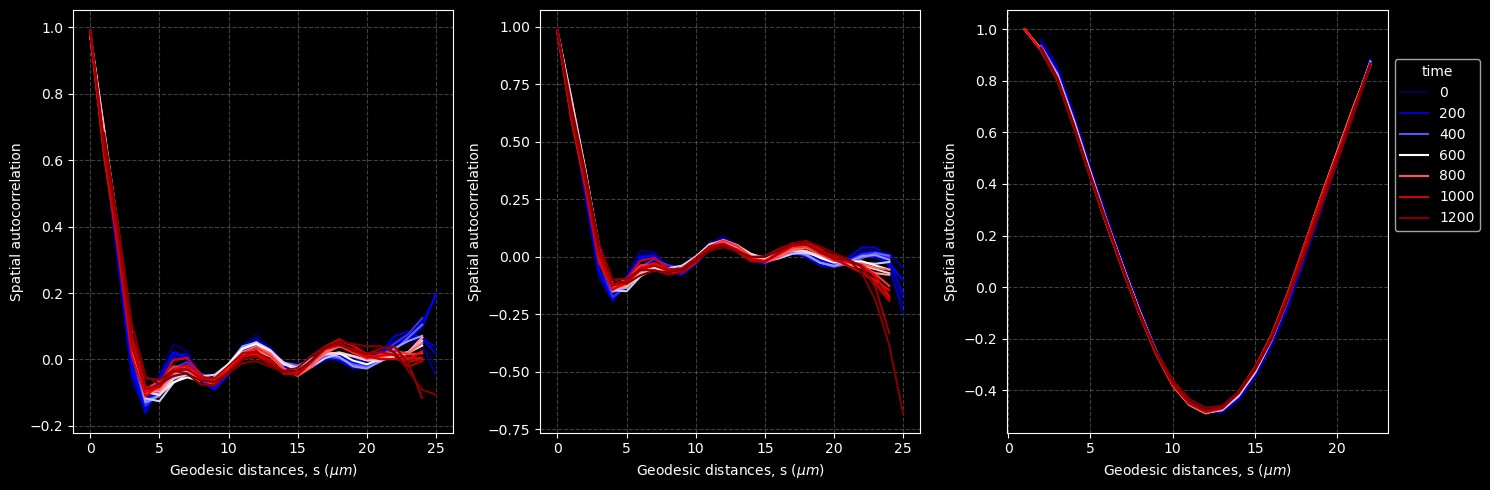

In [42]:
mpl.style.use('dark_background')
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(data=df_autocorrelations_total, x='distances', y='autocorrelation_total', hue='time', palette=colormap, ax=axes[0], legend=False)
sns.lineplot(data=df_autocorrelations_cell, x='distances', y='autocorrelation_cell', hue='time', palette=colormap, ax=axes[1], legend=False)
sns.lineplot(data=df_autocorrelations_tissue, x='distances', y='normalized_autocorrelation_tissue', hue='time', palette=colormap, ax=axes[2])

leg = axes[-1].get_legend()
leg.set_bbox_to_anchor(bbox=(1, 0.9))

for ax in axes:
    ax.set_xlabel('Geodesic distances, s ($\mu m$)')
    ax.set_ylabel('Spatial autocorrelation')
    ax.grid(which='major', linestyle='--', alpha=0.5, color='gray')
fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_autocorrelations_spatial.png'), dpi=300)

## Autocorrelations: Temporal

In [43]:
surface_total_stress_radial = list(results_stress_analysis[11][0])
surface_total_stress_radial += [df_total_stress['anisotropic_stress_total_radial'].to_numpy()]

In [44]:
df_over_time['temporal_autocorrelation_stress_total'] = measurements.temporal_autocorrelation(df_total_stress, 'anisotropic_stress_total_radial', frame_column_name='time')
df_over_time['temporal_autocorrelation_stress_cell'] = measurements.temporal_autocorrelation(df_total_stress, 'anisotropic_stress_cell', frame_column_name='time')
df_over_time['temporal_autocorrelation_stress_tissue'] = measurements.temporal_autocorrelation(df_tissue_stress, 'anisotropic_stress_tissue', frame_column_name='time')

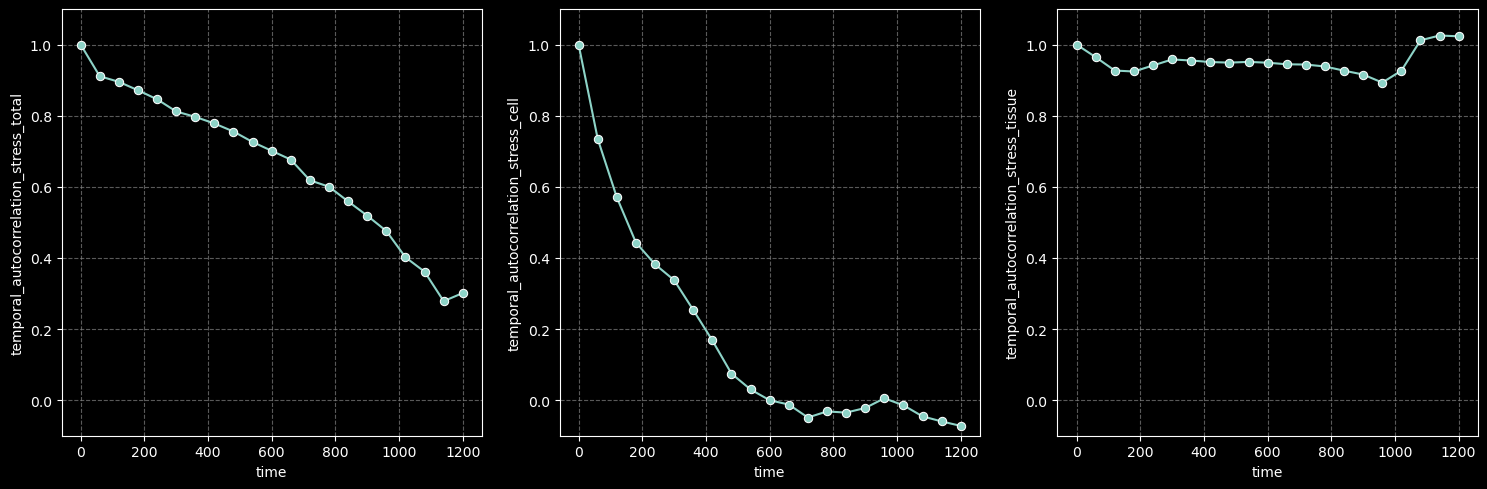

In [45]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(data=df_over_time, x='time', y='temporal_autocorrelation_stress_total', marker='o', ax=axes[0])
sns.lineplot(data=df_over_time, x='time', y='temporal_autocorrelation_stress_cell', marker='o', ax=axes[1])
sns.lineplot(data=df_over_time, x='time', y='temporal_autocorrelation_stress_tissue', marker='o', ax=axes[2])
fig.tight_layout()

for ax in axes:
    ax.set_ylim(-0.1, 1.1)
    ax.grid(which='major', color='gray', linestyle='--', alpha=0.7)

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_autocorrelations_temporal.png'), dpi=300)

## Ellipsoid deviation

In [46]:
ellipsoid_deviation_data = results_stress_analysis[0]
metadata = ellipsoid_deviation_data[1]['metadata']

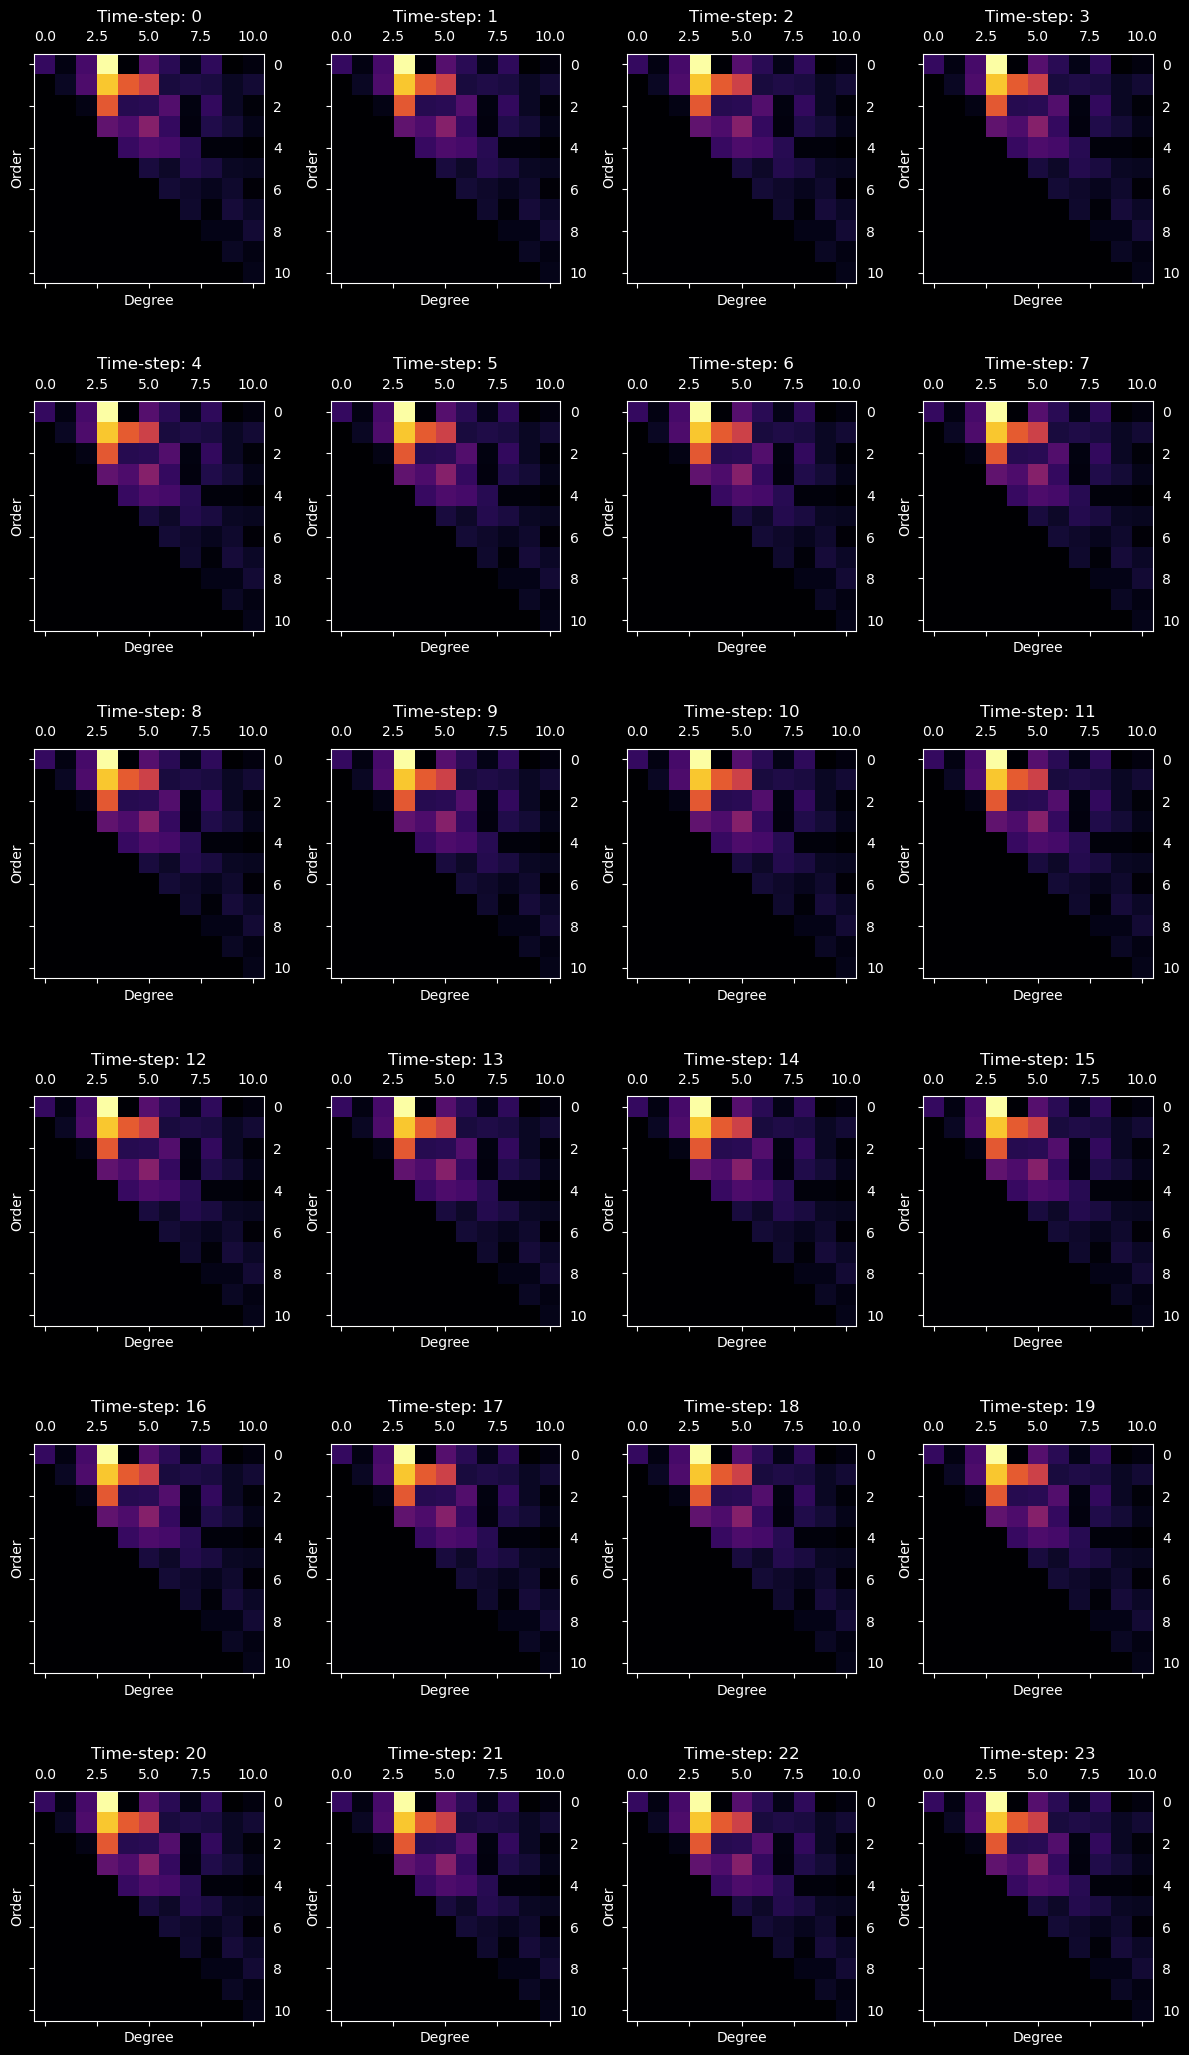

In [47]:
fig, axes = plt.subplots(ncols=4, nrows = n_frames//4 + 1, figsize=(12, n_frames))
for t, ax in enumerate(axes.flatten()):
    ax.imshow(np.triu(metadata['Elipsoid_deviation_contribution_matrix'][0]), cmap='inferno')
    ax.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=True)
    ax.set_xlabel('Degree')
    ax.set_ylabel('Order')
    ax.set_title(f'Time-step: {t}')

fig.tight_layout()

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'stress_ellipsoid_deviation_contribution_matrix.png'), dpi=300)

In [48]:
df_to_export = pd.DataFrame()
for col in df_over_time.columns:
    if isinstance(df_over_time[col].iloc[0], np.ndarray):
        continue
    if np.stack(df_over_time[col].to_numpy()).shape == (n_frames,):
        df_to_export[col] = df_over_time[col].to_numpy()

df_to_export.to_csv(os.path.join(save_directory, 'results_over_time.csv'), index=False)